# Predictions for Ethereum

In [1]:
import yfinance as yf
import ta
from sklearn.ensemble import RandomForestRegressor
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from darts.models import NaiveDrift, NaiveSeasonal, TCNModel, BlockRNNModel, TransformerModel, TFTModel
import matplotlib.pyplot as plt
import numpy as np
import torch
import plotly.graph_objects as go
from darts.metrics import mae, rmse, mse, mape



torch.manual_seed(1)
np.random.seed(1)



c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\utils.py:236: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
#actual: actual series
#prediction: predicted series
#print_single can be [True, False]. If True print one prediction associated to 1 model
#otherwise a list of predictions associated to different models
def print_graph(actual, prediction, print_single, model):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=actual.time_index,
                             y=actual.values().flatten(),
                             name='Real test points'))

    if print_single:
        fig.add_trace(go.Scatter(x=prediction.time_index,
                                 y=prediction.values().flatten(),
                                 name=f'Predicted points ({model})',
                                ))
    else:
        for key, pre in prediction.items():
            fig.add_trace(go.Scatter(x=pre.time_index,
                                     y=pre.values().flatten(),
                                     name=f'Predicted points ({key})',
                                    ))

    fig.update_layout(title_text = "Bitcoin prices")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    fig.show()

In [3]:
#actual: actual series
#prediction: predicted series
#print_single can be [True, False]. If True print one prediction associated to 1 model
#otherwise a list of predictions associated to different models
def print_graph_backtesting(actual, prediction, print_single, model, horizon):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=actual.time_index,
                             y=actual.values().flatten(),
                             name='Real test points'))

    if print_single:
        fig.add_trace(go.Scatter(x=prediction.time_index,
                                 y=prediction.values().flatten(),
                                 name=f'Predicted points ({model})',
                                ))
    else:
        for key, pre in prediction.items():
            fig.add_trace(go.Scatter(x=pre.time_index,
                                     y=pre.values().flatten(),
                                     name=f'Predicted points ({key})',
                                    ))

    fig.update_layout(title_text = f"Backtesting for Bitcoin prices with Forecasting Horizon = {horizon}")
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    fig.show()

In [4]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def fetch_crypto_compare_data(symbol, comparison_symbol, limit, to_timestamp):
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    params = {
        'fsym': symbol,
        'tsym': comparison_symbol,
        'limit': limit,
        'toTs': to_timestamp
    }
    response = requests.get(url, params=params)
    data = response.json()['Data']['Data']
    return data

def get_crypto_compare_ohlcv(symbol, comparison_symbol, start_date, end_date):
    df = pd.DataFrame()
    current_date = end_date

    while current_date > start_date:
        data = fetch_crypto_compare_data(symbol, comparison_symbol, 2000, int(current_date.timestamp()))
        current_date = datetime.fromtimestamp(data[0]['time'])
        df = pd.concat([pd.DataFrame(data), df], ignore_index=True)

    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df[(df['time'] >= start_date) & (df['time'] <= end_date)]
    return df

In [5]:
date_format = "%Y-%m-%d"
start_date = '2015-08-01'
end_date = '2019-08-22'


start_date = datetime.strptime(start_date, date_format)
end_date = datetime.strptime(end_date, date_format)
df = get_crypto_compare_ohlcv('ETH', 'USD', start_date, end_date)
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
print(pd.infer_freq(df.index))
del df['conversionType']
del df['conversionSymbol']
df = ta.utils.dropna(df)
df = ta.add_all_ta_features(
    df, "open", "high", "low", "close", "volumeto", fillna=True
)
df = df.fillna(0)

D


c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\ta\trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


In [6]:
df.rename(columns={'high': 'High', 'low': 'Low', 
                   'open': 'Open', 'volumefrom': 'Volume', 'close': 'Close'}, inplace=True)


# Feature engineering

In [7]:

split_index = int(len(df) * 0.8)  # 80% for training, 20% for testing
X_train = df.iloc[:split_index].drop('Close', axis=1)
y_train = df.iloc[:split_index]['Close']
X_test = df.iloc[split_index:].drop('Close', axis=1)
y_test = df.iloc[split_index:]['Close']

In [8]:
clf = RandomForestRegressor(n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [9]:
clf.score(X_test, y_test)

0.8655923009552874

In [10]:
features = {k: v for k, v in sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True)}

In [11]:
features

{'others_cr': 0.808908370372751,
 'Low': 0.04048150804755914,
 'High': 0.026171684340639358,
 'volatility_bbh': 0.011108233595578674,
 'volatility_kcl': 0.008389005940657468,
 'trend_ichimoku_conv': 0.008093277130203313,
 'volatility_dcm': 0.00785838502246732,
 'volume_adi': 0.006746476847416558,
 'volatility_bbm': 0.0067105192061682195,
 'momentum_kama': 0.0066711794095116305,
 'volatility_kcc': 0.006580486158287017,
 'trend_psar_up': 0.0062830719189308935,
 'volume_nvi': 0.006277116353933993,
 'trend_ema_fast': 0.005429945777509204,
 'trend_ichimoku_base': 0.0052956172789109125,
 'volatility_dch': 0.005256657049438868,
 'Open': 0.004409988576828739,
 'volume_vpt': 0.004316419322252029,
 'volatility_kch': 0.0040942961285122155,
 'trend_ema_slow': 0.0040680316644975175,
 'trend_ichimoku_b': 0.0039262845625594525,
 'trend_sma_fast': 0.003826286421689743,
 'trend_sma_slow': 0.002727778068140172,
 'volume_vwap': 0.0026390424659311676,
 'trend_ichimoku_a': 0.0026112554706990507,
 'momentum

In [12]:
filtered_features = {feature: importance for feature, importance in features.items() if importance >= 0.01}


In [13]:
filtered_features

{'others_cr': 0.808908370372751,
 'Low': 0.04048150804755914,
 'High': 0.026171684340639358,
 'volatility_bbh': 0.011108233595578674}

In [14]:
filtered_feature_names = list(filtered_features.keys())
df = df.reset_index()
covs= TimeSeries.from_dataframe(df, time_col="time", value_cols=filtered_feature_names)
covs = covs.astype(np.float32)
target = TimeSeries.from_dataframe(df, time_col="time", value_cols=["Close"])
target = target.astype(np.float32)

# Create Train, Validation and Test Set + Past and Future Covariates

In [15]:
#create train and validation series and scale them
test_set_size = 93

split = int((len(df) - test_set_size) * 0.8)

val_set_size = int(len(df) - test_set_size - split)

train_target = target[: -(val_set_size + test_set_size)]

val_target = target[-(val_set_size + test_set_size) : -test_set_size]

test_target = target[-(test_set_size) :]

scaler_target = Scaler()
scaler_features = Scaler()

scaler_target = scaler_target.fit(train_target)


train_scaled = scaler_target.transform(train_target)
val_scaled = scaler_target.transform(val_target)
test_scaled = scaler_target.transform(test_target)

target_scaled = concatenate([train_scaled, val_scaled, test_scaled])

In [16]:
val_set_size

277

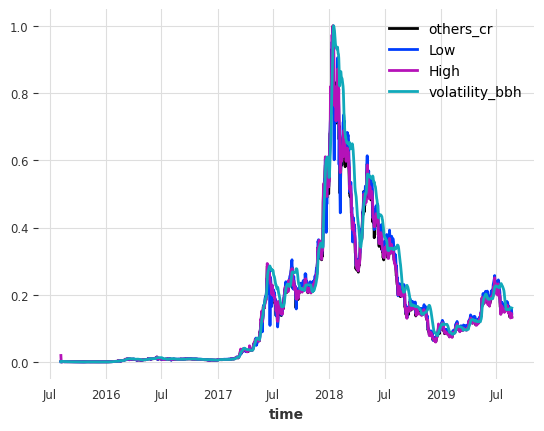

In [17]:
past_covs = concatenate(
    [
        dt_attr(target.time_index, "month", dtype=np.float32),
        dt_attr(target.time_index, "year", dtype=np.float32),
        dt_attr(target.time_index, "day", dtype=np.float32),
        dt_attr(target.time_index, "dayofweek", dtype=np.float32),
        dt_attr(target.time_index, "week", dtype=np.float32),
        dt_attr(target.time_index, "dayofyear", dtype=np.float32),
        covs,
    ],
    axis="component",
)


scaler_ft_past = Scaler()

past_covs = scaler_ft_past.fit_transform(past_covs)
idx = past_covs.columns[6:]
tech_analysis_idx = past_covs[idx.to_list()]
tech_analysis_idx.plot()
plt.show()

In [18]:
future_covs = concatenate(
    [
        dt_attr(target.time_index, "month", dtype=np.float32),
        dt_attr(target.time_index, "year", dtype=np.float32),
        dt_attr(target.time_index, "day", dtype=np.float32),
        dt_attr(target.time_index, "dayofweek", dtype=np.float32),
        dt_attr(target.time_index, "week", dtype=np.float32),
        dt_attr(target.time_index, "dayofyear", dtype=np.float32),
    ],
    axis="component",
)


scaler_ft_future = Scaler()


future_covs = scaler_ft_future.fit_transform(future_covs)

In [19]:
val = scaler_target.inverse_transform(val_scaled)

test = scaler_target.inverse_transform(test_scaled)

# Create csv file where to store all of the Error Metrics

In [20]:
import csv

headers = ['Model', 'MAE', 'RMSE', 'MSE', 'MAPE']
separator = ['-', '-', '-', '-', '-']

with open('./results/error_metrics_ETH.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(headers)

def add_row(row):
  with open('./results/error_metrics_ETH.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(row)

# Naive Models

In [21]:
models = {}
predictions = {}

models['naive_drift_model'] = NaiveDrift()
models['naive_model'] = NaiveSeasonal()
models['naive_seasonal_model'] = NaiveSeasonal(7)


for key, model in models.items():
    model.fit(train_scaled)
    predictions[key] = model.predict(len(val_scaled))
    predictions[key] = scaler_target.inverse_transform(predictions[key])

In [22]:
print_graph(val, predictions, False, None)

In [23]:
for key, prediction in predictions.items():
    print(f"MAE of {key}: {mae(val, prediction)}")
    print(f"RMSE of {key}: {rmse(val, prediction)}")
    print(f"MSE of {key}: {mse(val, prediction)}")
    print(f"MAPE of {key}: {mape(val, prediction)}")
    print("\n")
    row = [f'{key}', mae(val, prediction), rmse(val, prediction), mse(val, prediction), mape(val, prediction) ]
    add_row(row)

add_row(separator)

MAE of naive_drift_model: 154.32620239257812
RMSE of naive_drift_model: 167.0364227294922
MSE of naive_drift_model: 27901.166015625
MAPE of naive_drift_model: 111.30373477935791


MAE of naive_model: 118.73677062988281
RMSE of naive_model: 129.23236083984375
MSE of naive_model: 16701.00390625
MAPE of naive_model: 86.7102563381195


MAE of naive_seasonal_model: 131.82171630859375
RMSE of naive_seasonal_model: 142.84121704101562
MSE of naive_seasonal_model: 20403.61328125
MAPE of naive_seasonal_model: 95.24239897727966




# Backtesting Naive Drift Model

In [24]:
bt_horizons = [1, 7 ,30]
bt_start=test_target.time_index[0]


In [25]:
backtesting_Drift = []
backtesting_Naive = []
backtesting_NaiveSeasonal = []
backtesting_ExpSmoothing = []
backtesting_Arima = []
backtesting_Prophet = []
backtesting_Tbats = []

In [26]:

for h in bt_horizons:
  hist_Drift = models['naive_drift_model'].historical_forecasts(
          target_scaled,
          start= bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_Drift = scaler_target.inverse_transform(hist_Drift)
  backtesting_Drift.append(hist_predict_Drift)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

In [27]:
len(backtesting_Drift)

3

In [28]:
for b in backtesting_Drift:
  h = bt_horizons[backtesting_Drift.index(b)]
  print_graph_backtesting(test, b, True, 'naive_drift_model',h)

In [29]:
add_row(['Backtesting Naive Drift Model','','','',''])
for b in backtesting_Drift:
  print(f"MAE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Drift Model forecasting horizon = {bt_horizons[backtesting_Drift.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive Drift fh={bt_horizons[backtesting_Drift.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Drift Model forecasting horizon = 1: 8.410723686218262
RMSE of Naive Drift Model forecasting horizon = 1: 11.769231796264648
MSE of Naive Drift Model forecasting horizon = 1: 138.5148162841797
MAPE of Naive Drift Model forecasting horizon = 1: 3.382975235581398


MAE of Naive Drift Model forecasting horizon = 7: 21.406469345092773
RMSE of Naive Drift Model forecasting horizon = 7: 28.93387794494629
MSE of Naive Drift Model forecasting horizon = 7: 837.1692504882812
MAPE of Naive Drift Model forecasting horizon = 7: 8.808209002017975


MAE of Naive Drift Model forecasting horizon = 30: 60.043121337890625
RMSE of Naive Drift Model forecasting horizon = 30: 67.42237091064453
MSE of Naive Drift Model forecasting horizon = 30: 4545.7763671875
MAPE of Naive Drift Model forecasting horizon = 30: 25.06420612335205




# Backtesting Naive Model

In [30]:
for h in bt_horizons:
  hist_Naive = models['naive_model'].historical_forecasts(
          target_scaled,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_Naive = scaler_target.inverse_transform(hist_Naive)
  backtesting_Naive.append(hist_predict_Naive)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

In [31]:
for b in backtesting_Naive:
  h = bt_horizons[backtesting_Naive.index(b)]
  print_graph_backtesting(test, b, True, 'naive_model',h)

In [32]:
add_row(['Backtesting Naive Model','','','',''])
for b in backtesting_Naive:
  print(f"MAE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Model forecasting horizon = {bt_horizons[backtesting_Naive.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive fh={bt_horizons[backtesting_Naive.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Model forecasting horizon = 1: 8.420644760131836
RMSE of Naive Model forecasting horizon = 1: 11.755032539367676
MSE of Naive Model forecasting horizon = 1: 138.1807861328125
MAPE of Naive Model forecasting horizon = 1: 3.3850010484457016


MAE of Naive Model forecasting horizon = 7: 21.29483985900879
RMSE of Naive Model forecasting horizon = 7: 28.690282821655273
MSE of Naive Model forecasting horizon = 7: 823.13232421875
MAPE of Naive Model forecasting horizon = 7: 8.730535954236984


MAE of Naive Model forecasting horizon = 30: 60.27064514160156
RMSE of Naive Model forecasting horizon = 30: 66.99532318115234
MSE of Naive Model forecasting horizon = 30: 4488.37353515625
MAPE of Naive Model forecasting horizon = 30: 24.88541007041931




# Backtesting Naive Seasonal Model

In [33]:
for h in bt_horizons:
  hist_NaiveSeasonal = models['naive_seasonal_model'].historical_forecasts(
          target_scaled,
          start=bt_start,
          forecast_horizon=h,
          stride=1,
          verbose=True,
    )
  hist_predict_NaiveSeasonal = scaler_target.inverse_transform(hist_NaiveSeasonal)
  backtesting_NaiveSeasonal.append(hist_predict_NaiveSeasonal)

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

In [34]:
for b in backtesting_NaiveSeasonal:
  h = bt_horizons[backtesting_NaiveSeasonal.index(b)]
  print_graph_backtesting(test, b, True, 'naive_seasonal_model',h)

In [35]:
add_row(['Backtesting Naive Seasonal Model','','','',''])
for b in backtesting_NaiveSeasonal:
  print(f"MAE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Naive Seasonal Model forecasting horizon = {bt_horizons[backtesting_NaiveSeasonal.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Naive Seasonal fh={bt_horizons[backtesting_NaiveSeasonal.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Naive Seasonal Model forecasting horizon = 1: 21.29483985900879
RMSE of Naive Seasonal Model forecasting horizon = 1: 28.690282821655273
MSE of Naive Seasonal Model forecasting horizon = 1: 823.13232421875
MAPE of Naive Seasonal Model forecasting horizon = 1: 8.730535954236984


MAE of Naive Seasonal Model forecasting horizon = 7: 21.714597702026367
RMSE of Naive Seasonal Model forecasting horizon = 7: 29.238662719726562
MSE of Naive Seasonal Model forecasting horizon = 7: 854.8993530273438
MAPE of Naive Seasonal Model forecasting horizon = 7: 8.916816115379333


MAE of Naive Seasonal Model forecasting horizon = 30: 56.44984436035156
RMSE of Naive Seasonal Model forecasting horizon = 30: 63.56796646118164
MSE of Naive Seasonal Model forecasting horizon = 30: 4040.88623046875
MAPE of Naive Seasonal Model forecasting horizon = 30: 24.462221562862396




# Graphs of the Naive Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [36]:
predictions_naive_1= {}
predictions_naive_7= {}
predictions_naive_30= {}

naive_models = ['Naive', 'Naive Drift', 'Naive Seasonal']
backtesting_naive =[backtesting_Naive, backtesting_Drift, backtesting_NaiveSeasonal]
predictions_naive = [predictions_naive_1, predictions_naive_7, predictions_naive_30]

for i in predictions_naive:
    for j in naive_models:
        i[j] = backtesting_naive[naive_models.index(j)][predictions_naive.index(i)]

In [37]:
#print

print_graph_backtesting(test, predictions_naive_1, False, None, 1)
print_graph_backtesting(test, predictions_naive_7, False, None, 7)
print_graph_backtesting(test, predictions_naive_30, False, None, 30)


# Random Forest

In [38]:
from darts.models import RandomForest

random_forest_model = RandomForest(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    
    lags_past_covariates=[-i for i in range(1, 31)] + [-90, -180],

    n_estimators=100,  # Number of trees in the forest
    max_depth=15,  # Maximum depth of each tree
)

In [39]:
random_forest_model.fit(train_scaled, past_covariates = past_covs)
random_forest_prediction = random_forest_model.predict(n = len(val_scaled))
random_forest_prediction = scaler_target.inverse_transform(random_forest_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [40]:
print_graph(val, random_forest_prediction, True, 'Random Forest')

In [41]:
print(f"MAE of Random Forest: {mae(val, random_forest_prediction)}")
print(f"RMSE of Random Forest: {rmse(val, random_forest_prediction)}")
print(f"MSE of Random Forest: {mse(val, random_forest_prediction)}")
print(f"MAPE of Random Forest: {mape(val, random_forest_prediction)}")
row = ['Random Forest', mae(val, random_forest_prediction), rmse(val, random_forest_prediction), mse(val, random_forest_prediction), mape(val, random_forest_prediction) ]
add_row(row)
add_row(separator)

MAE of Random Forest: 39.0888906933834
RMSE of Random Forest: 46.35448125220177
MSE of Random Forest: 2148.7379321607254
MAPE of Random Forest: 29.952257689001755


# Backtesting Random Forest

In [42]:
backtesting_RF = []

bt_horizons = [1, 7 ,30]

bt_start=test.time_index[0]

for h in bt_horizons:

  hist_RF = random_forest_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_RF = scaler_target.inverse_transform(hist_RF)
  backtesting_RF.append(hist_predict_RF)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/93 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/93 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [43]:
for b in backtesting_RF:
  h = bt_horizons[backtesting_RF.index(b)]
  print_graph_backtesting(test, b, True, 'Random Forest',h)

In [44]:
add_row(['Backtesting Random Forest','','','',''])
for b in backtesting_RF:
  print(f"MAE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mae(test, b)}")
  print(f"RMSE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {rmse(test, b)}")
  print(f"MSE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mse(test, b)}")
  print(f"MAPE of RF forecasting horizon = {bt_horizons[backtesting_RF.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Random Forest fh={bt_horizons[backtesting_RF.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of RF forecasting horizon = 1: 11.918640041502725
RMSE of RF forecasting horizon = 1: 15.467602659177748
MSE of RF forecasting horizon = 1: 239.24673202220254
MAPE of RF forecasting horizon = 1: 5.002263315737562


MAE of RF forecasting horizon = 7: 14.64929417674217
RMSE of RF forecasting horizon = 7: 18.562559740738582
MSE of RF forecasting horizon = 7: 344.5686241284888
MAPE of RF forecasting horizon = 7: 6.137851707914738


MAE of RF forecasting horizon = 30: 14.57529082679642
RMSE of RF forecasting horizon = 30: 18.56888465678513
MSE of RF forecasting horizon = 30: 344.80347739699016
MAPE of RF forecasting horizon = 30: 6.104936689644391




# LSTM Model

Best parameters: {'hidden_dim': 104,
 'r_rnn_layers': 4,
 'dropout': 0.18390991552139796,
 'lr': 0.00014678997505613995,
 'encoders': False}

In [46]:
LSTM_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    hidden_dim=43,
    model='LSTM',
    n_rnn_layers=3,
    dropout= 0.28657130197081176,
    optimizer_kwargs={'lr':0.00048112733032723944},
)

In [47]:
LSTM_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 39.9 K
4 | fc            | Sequential       | 308   
---------------------------------------------------
40.2 K    Trainable params
0         Non-trainable

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(model=LSTM, hidden_dim=43, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.28657130197081176, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.00048112733032723944})

In [48]:
LSTM_model_prediction = LSTM_model.predict(n = len(val_scaled))
LSTM_model_prediction = scaler_target.inverse_transform(LSTM_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [49]:
print_graph(val, LSTM_model_prediction, True, 'LSTM model')

In [50]:
print(f"MAE of LSTM: {mae(val, LSTM_model_prediction)}")
print(f"RMSE of LSTM: {rmse(val, LSTM_model_prediction)}")
print(f"MSE of LSTM: {mse(val, LSTM_model_prediction)}")
print(f"MAPE of LSTM: {mape(val, LSTM_model_prediction)}")
row = ['LSTM', mae(val, LSTM_model_prediction), rmse(val, LSTM_model_prediction), mse(val, LSTM_model_prediction), mape(val, LSTM_model_prediction) ]
add_row(row)
add_row(separator)

MAE of LSTM: 127.82378387451172
RMSE of LSTM: 172.47251892089844
MSE of LSTM: 29746.76953125
MAPE of LSTM: 93.64109635353088


# Backtesting LSTM

In [51]:
backtesting_LSTM = []

for h in bt_horizons:

  hist_LSTM = LSTM_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_LSTM = scaler_target.inverse_transform(hist_LSTM)
  backtesting_LSTM.append(hist_predict_LSTM)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [52]:
for b in backtesting_LSTM:
  h = bt_horizons[backtesting_LSTM.index(b)]
  print_graph_backtesting(test, b, True, 'LSTM model',h)

In [53]:
add_row(['Backtesting LSTM Model','','','',''])
for b in backtesting_LSTM:
  print(f"MAE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mae(test, b)}")
  print(f"RMSE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {rmse(test, b)}")
  print(f"MSE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mse(test, b)}")
  print(f"MAPE of LSTM forecasting horizon = {bt_horizons[backtesting_LSTM.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'LSTM fh={bt_horizons[backtesting_LSTM.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of LSTM forecasting horizon = 1: 60.645748138427734
RMSE of LSTM forecasting horizon = 1: 68.25737762451172
MSE of LSTM forecasting horizon = 1: 4659.0693359375
MAPE of LSTM forecasting horizon = 1: 24.327561259269714


MAE of LSTM forecasting horizon = 7: 83.02507019042969
RMSE of LSTM forecasting horizon = 7: 90.04710388183594
MSE of LSTM forecasting horizon = 7: 8108.48046875
MAPE of LSTM forecasting horizon = 7: 33.875566720962524


MAE of LSTM forecasting horizon = 30: 111.57747650146484
RMSE of LSTM forecasting horizon = 30: 118.8793716430664
MSE of LSTM forecasting horizon = 30: 14132.3046875
MAPE of LSTM forecasting horizon = 30: 45.347025990486145




# VanillaRNN Model

Best parameters:
{'hidden_dim': 31,
 'n_rnn_layers': 1,
 'dropout': 0.34008569567908437,
 'lr': 0.0009241588491743642,
 'encoders': False}

In [54]:
vanillaRNN_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    model='RNN',
    hidden_dim=46,
    n_rnn_layers=3,
    dropout=0.02622050492850875,
    optimizer_kwargs={'lr': 0.0009977736177203696},
)

In [55]:
vanillaRNN_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 11.4 K
4 | fc            | Sequential       | 329   
---------------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(model=RNN, hidden_dim=46, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.02622050492850875, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.0009977736177203696})

In [56]:
vanillaRNN_model_prediction = vanillaRNN_model.predict(n = len(val_scaled))
vanillaRNN_model_prediction = scaler_target.inverse_transform(vanillaRNN_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [57]:
print_graph(val, vanillaRNN_model_prediction, True, 'Vanilla RNN')

In [58]:
print(f"MAE of VanillaRNN: {mae(val, vanillaRNN_model_prediction)}")
print(f"RMSE of VanillaRNN: {rmse(val, vanillaRNN_model_prediction)}")
print(f"MSE of VanillaRNN: {mse(val, vanillaRNN_model_prediction)}")
print(f"MAPE of VanillaRNN: {mape(val, vanillaRNN_model_prediction)}")
row = ['VanillaRNN', mae(val, vanillaRNN_model_prediction), rmse(val, vanillaRNN_model_prediction), mse(val, vanillaRNN_model_prediction), mape(val, vanillaRNN_model_prediction)]
add_row(row)
add_row(separator)

MAE of VanillaRNN: 29.928577423095703
RMSE of VanillaRNN: 39.35988235473633
MSE of VanillaRNN: 1549.2003173828125
MAPE of VanillaRNN: 19.683563709259033


# Backtesting VanillaRNN

In [59]:
backtesting_VanillaRNN = []

for h in bt_horizons:

  hist_VanillaRNN = vanillaRNN_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_VanillaRNN = scaler_target.inverse_transform(hist_VanillaRNN)
  backtesting_VanillaRNN.append(hist_predict_VanillaRNN)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [60]:
for b in backtesting_VanillaRNN:
  h = bt_horizons[backtesting_VanillaRNN.index(b)]
  print_graph_backtesting(test, b, True, 'Vanilla RNN',h)

In [61]:
add_row(['Backtesting RNN Model','','','',''])
for b in backtesting_VanillaRNN:
  print(f"MAE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mae(test, b)}")
  print(f"RMSE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {rmse(test, b)}")
  print(f"MSE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mse(test, b)}")
  print(f"MAPE of RNN forecasting horizon = {bt_horizons[backtesting_VanillaRNN.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'RNN fh={bt_horizons[backtesting_VanillaRNN.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of RNN forecasting horizon = 1: 13.51501750946045
RMSE of RNN forecasting horizon = 1: 17.581478118896484
MSE of RNN forecasting horizon = 1: 309.1083984375
MAPE of RNN forecasting horizon = 1: 5.516848340630531


MAE of RNN forecasting horizon = 7: 41.16931915283203
RMSE of RNN forecasting horizon = 7: 47.84995651245117
MSE of RNN forecasting horizon = 7: 2289.6181640625
MAPE of RNN forecasting horizon = 7: 17.472457885742188


MAE of RNN forecasting horizon = 30: 48.48984146118164
RMSE of RNN forecasting horizon = 30: 55.31263732910156
MSE of RNN forecasting horizon = 30: 3059.48779296875
MAPE of RNN forecasting horizon = 30: 20.65945863723755




# GRU Model

Best parameters: {'hidden_dim': 75,
 'r_rnn_layers': 1,
 'dropout': 0.007824503730612165,
 'lr': 0.000566687831423731,
 'encoders': False}

In [62]:
GRU_model = BlockRNNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    model='GRU',
    hidden_dim=153,
    n_rnn_layers=1,
    dropout=0.0707239073983959,
    optimizer_kwargs={'lr': 2.3436557068849167e-05},
)

In [63]:
GRU_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0707239073983959 and num_layers=1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 76.2 K
4 | fc            | Sequential       | 1.1 K 
---------------------------------------------------
77.3 K    Trainable params
0         Non-trainable params
77.3 K    Total params
0.309     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


BlockRNNModel(model=GRU, hidden_dim=153, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0707239073983959, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 2.3436557068849167e-05})

In [64]:
GRU_model_prediction = GRU_model.predict(n = len(val_scaled))
GRU_model_prediction = scaler_target.inverse_transform(GRU_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [65]:
print_graph(val, GRU_model_prediction, True, 'GRU Model')

In [66]:
print(f"MAE of GRU: {mae(val, GRU_model_prediction)}")
print(f"RMSE of GRU: {rmse(val, GRU_model_prediction)}")
print(f"MSE of GRU: {mse(val, GRU_model_prediction)}")
print(f"MAPE of GRU: {mape(val, GRU_model_prediction)}")
row = ['GRU Model', mae(val, GRU_model_prediction), rmse(val, GRU_model_prediction), mse(val, GRU_model_prediction), mape(val, GRU_model_prediction) ]
add_row(row)
add_row(separator)

MAE of GRU: 58.448055267333984
RMSE of GRU: 69.48444366455078
MSE of GRU: 4828.08837890625
MAPE of GRU: 39.58706259727478


# Backtesting GRU

In [67]:
backtesting_GRU = []

for h in bt_horizons:

  hist_GRU = GRU_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_GRU = scaler_target.inverse_transform(hist_GRU)
  backtesting_GRU.append(hist_predict_GRU)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [68]:
for b in backtesting_GRU:
  h = bt_horizons[backtesting_GRU.index(b)]
  print_graph_backtesting(test, b, True, 'GRU model',h)

In [69]:
add_row(['Backtesting GRU Model','','','',''])
for b in backtesting_GRU:
  print(f"MAE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mae(test, b)}")
  print(f"RMSE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {rmse(test, b)}")
  print(f"MSE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mse(test, b)}")
  print(f"MAPE of GRU forecasting horizon = {bt_horizons[backtesting_GRU.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'GRU fh={bt_horizons[backtesting_GRU.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of GRU forecasting horizon = 1: 37.79287338256836
RMSE of GRU forecasting horizon = 1: 44.58039093017578
MSE of GRU forecasting horizon = 1: 1987.4112548828125
MAPE of GRU forecasting horizon = 1: 16.571977734565735


MAE of GRU forecasting horizon = 7: 43.8386116027832
RMSE of GRU forecasting horizon = 7: 54.55590057373047
MSE of GRU forecasting horizon = 7: 2976.34619140625
MAPE of GRU forecasting horizon = 7: 19.41489577293396


MAE of GRU forecasting horizon = 30: 52.70026779174805
RMSE of GRU forecasting horizon = 30: 65.49203491210938
MSE of GRU forecasting horizon = 30: 4289.20654296875
MAPE of GRU forecasting horizon = 30: 23.549608886241913




# Transformer Model

Best params: {'d_model': 88, 'nhead': 4, 'num_encoder_layers': 4, 'num_decoder_layers': 1, 'dropout': 0.14295488378943239, 'lr': 0.00046254166100837376, 'encoders': False}

In [70]:
transformer_model = TransformerModel(
    input_chunk_length = 21,
    output_chunk_length = 7,
    d_model=92,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=4,
    dropout=0.11249672199493155,
    optimizer_kwargs={'lr': 0.0002891919462695517},
)

In [71]:
transformer_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

c:\Users\mirja\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning:

enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 1.1 K 
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 914 K 
6 | decoder             | Linear              | 651   
------

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TransformerModel(d_model=92, nhead=4, num_encoder_layers=2, num_decoder_layers=4, dim_feedforward=512, dropout=0.11249672199493155, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.0002891919462695517})

In [72]:
transformer_model_prediction = transformer_model.predict(n = len(val_scaled))
transformer_model_prediction = scaler_target.inverse_transform(transformer_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [73]:
print_graph(val, transformer_model_prediction, True, 'Transformer Model')

In [74]:
print(f"MAE of Transformer Model: {mae(val, transformer_model_prediction)}")
print(f"RMSE of Transformer Model: {rmse(val, transformer_model_prediction)}")
print(f"MSE of Transformer Model: {mse(val, transformer_model_prediction)}")
print(f"MAPE of Transformer Model: {mape(val, transformer_model_prediction)}")
row = ['Transformer Model', mae(val, transformer_model_prediction), rmse(val, transformer_model_prediction), mse(val, transformer_model_prediction), mape(val, transformer_model_prediction) ]
add_row(row)
add_row(separator)

MAE of Transformer Model: 169.6558380126953
RMSE of Transformer Model: 184.15823364257812
MSE of Transformer Model: 33914.25390625
MAPE of Transformer Model: 115.56578874588013


# Backtesting Transformer Model

In [75]:
backtesting_Transformer = []

for h in bt_horizons:

  hist_Transformer = transformer_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_Transformer = scaler_target.inverse_transform(hist_Transformer)
  backtesting_Transformer.append(hist_predict_Transformer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [76]:
for b in backtesting_Transformer:
  h = bt_horizons[backtesting_Transformer.index(b)]
  print_graph_backtesting(test, b, True, 'Transformer Model',h)

In [77]:
add_row(['Backtesting Transformer Model','','','',''])
for b in backtesting_Transformer:
  print(f"MAE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mae(test, b)}")
  print(f"RMSE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {rmse(test, b)}")
  print(f"MSE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mse(test, b)}")
  print(f"MAPE of Transformer Model forecasting horizon = {bt_horizons[backtesting_Transformer.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Transformer fh={bt_horizons[backtesting_Transformer.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of Transformer Model forecasting horizon = 1: 132.40054321289062
RMSE of Transformer Model forecasting horizon = 1: 133.4237060546875
MSE of Transformer Model forecasting horizon = 1: 17801.884765625
MAPE of Transformer Model forecasting horizon = 1: 54.85875606536865


MAE of Transformer Model forecasting horizon = 7: 166.79116821289062
RMSE of Transformer Model forecasting horizon = 7: 169.9891815185547
MSE of Transformer Model forecasting horizon = 7: 28896.322265625
MAPE of Transformer Model forecasting horizon = 7: 68.91725659370422


MAE of Transformer Model forecasting horizon = 30: 213.5266876220703
RMSE of Transformer Model forecasting horizon = 30: 217.4813232421875
MSE of Transformer Model forecasting horizon = 30: 47298.125
MAPE of Transformer Model forecasting horizon = 30: 87.83641457557678




# TFT Model

best parameters: {'hidden_size': 30,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.06118422728497173,
 'hidden_continuous_size': 10,
 'lr': 0.005081664304452033}

In [78]:
TFT_model = TFTModel(
    input_chunk_length=21,
    output_chunk_length=7,
    hidden_size=32,
    lstm_layers=1,
    num_attention_heads=2,
    dropout=0.17226530732530446,
    hidden_continuous_size=9,
    optimizer_kwargs={'lr': 0.008671478870787766},
)

In [79]:
TFT_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    future_covariates = future_covs
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 21.1 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 6.7 K 
6  | static_context_grn                | _GatedResidualNetwork            | 4.3 K 
7  | static_context_hidden_encoder_grn | _GatedResid

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TFTModel(hidden_size=32, lstm_layers=1, num_attention_heads=2, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.17226530732530446, hidden_continuous_size=9, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.008671478870787766})

In [80]:
TFT_model_prediction = TFT_model.predict(n = len(val_scaled))
TFT_model_prediction = scaler_target.inverse_transform(TFT_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [81]:
print_graph(val, TFT_model_prediction, True, 'TFT Model')

In [82]:
print(f"MAE of TFT Model: {mae(val, TFT_model_prediction)}")
print(f"RMSE of TFT Model: {rmse(val, TFT_model_prediction)}")
print(f"MSE of TFT Model: {mse(val, TFT_model_prediction)}")
print(f"MAPE of TFT Model: {mape(val, TFT_model_prediction)}")
row = ['TFT', mae(val, TFT_model_prediction), rmse(val, TFT_model_prediction), mse(val, TFT_model_prediction), mape(val, TFT_model_prediction) ]
add_row(row)
add_row(separator)

MAE of TFT Model: 415.6932067871094
RMSE of TFT Model: 506.64208984375
MSE of TFT Model: 256686.203125
MAPE of TFT Model: 304.9217700958252


# Backtesting TFT Model

In [83]:
backtesting_TFT = []

for h in bt_horizons:

  hist_TFT = TFT_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          future_covariates = future_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_TFT = scaler_target.inverse_transform(hist_TFT)
  backtesting_TFT.append(hist_predict_TFT)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [84]:
for b in backtesting_TFT:
  h = bt_horizons[backtesting_TFT.index(b)]
  print_graph_backtesting(test, b, True, 'TFT Model',h)

In [85]:
add_row(['Backtesting TFT Model','','','',''])
for b in backtesting_TFT:
  print(f"MAE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mae(test, b)}")
  print(f"RMSE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {rmse(test, b)}")
  print(f"MSE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mse(test, b)}")
  print(f"MAPE of TFT Model forecasting horizon = {bt_horizons[backtesting_TFT.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'TFT fh={bt_horizons[backtesting_TFT.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of TFT Model forecasting horizon = 1: 62.18141174316406
RMSE of TFT Model forecasting horizon = 1: 69.01591491699219
MSE of TFT Model forecasting horizon = 1: 4763.1962890625
MAPE of TFT Model forecasting horizon = 1: 25.66923499107361


MAE of TFT Model forecasting horizon = 7: 62.81752395629883
RMSE of TFT Model forecasting horizon = 7: 73.57706451416016
MSE of TFT Model forecasting horizon = 7: 5413.58447265625
MAPE of TFT Model forecasting horizon = 7: 27.15774178504944


MAE of TFT Model forecasting horizon = 30: 106.91417694091797
RMSE of TFT Model forecasting horizon = 30: 131.29566955566406
MSE of TFT Model forecasting horizon = 30: 17238.5546875
MAPE of TFT Model forecasting horizon = 30: 45.08301615715027




# NBEATS Model

Best parameters: {'num_stacks': 19,
 'num_blocks': 4,
 'num_layers': 4,
 'layer_widths': 378,
 'expansion_coefficient_dim': 8,
 'dropout': 0.007293860107310261,
 'lr': 0.0005903374698873167,
 'encoders': True}

In [86]:
from darts.models import NBEATSModel

NBEATS_model = NBEATSModel(
    input_chunk_length=21,
    output_chunk_length=7,
    num_stacks=16,
    num_blocks=5,
    num_layers=3,
    layer_widths=386,
    expansion_coefficient_dim=10,
    dropout=0.019877849352538418,
    optimizer_kwargs={'lr': 6.135769404419855e-05},
    
)

In [87]:

NBEATS_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 32.0 M
---------------------------------------------------
31.9 M    Trainable params
6.4 K     Non-trainable params
32.0 M    Total params
127.822   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(generic_architecture=True, num_stacks=16, num_blocks=5, num_layers=3, layer_widths=386, expansion_coefficient_dim=10, trend_polynomial_degree=2, dropout=0.019877849352538418, activation=ReLU, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 6.135769404419855e-05})

In [88]:
NBEATS_model_prediction = NBEATS_model.predict(n=len(val_scaled))
NBEATS_model_prediction = scaler_target.inverse_transform(NBEATS_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [89]:
print_graph(val, NBEATS_model_prediction, True, 'NBEATS Model')

In [90]:
print(f"MAE of NBEATS: {mae(val, NBEATS_model_prediction)}")
print(f"RMSE of NBEATS: {rmse(val, NBEATS_model_prediction)}")
print(f"MSE of NBEATS: {mse(val, NBEATS_model_prediction)}")
print(f"MAPE of NBEATS: {mape(val, NBEATS_model_prediction)}")
row = ['NBEATS', mae(val, NBEATS_model_prediction), rmse(val, NBEATS_model_prediction), mse(val, NBEATS_model_prediction), mape(val, NBEATS_model_prediction) ]
add_row(row)
add_row(separator)

MAE of NBEATS: 93.89244842529297
RMSE of NBEATS: 106.39459228515625
MSE of NBEATS: 11319.80859375
MAPE of NBEATS: 64.90203142166138


# Backtesting NBEATS Model

In [91]:
backtesting_NBEATS = []

for h in bt_horizons:

  hist_NBEATS = NBEATS_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_NBEATS = scaler_target.inverse_transform(hist_NBEATS)
  backtesting_NBEATS.append(hist_predict_NBEATS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [92]:
for b in backtesting_NBEATS:
  h = bt_horizons[backtesting_NBEATS.index(b)]
  print_graph_backtesting(test, b, True, 'NBEATS Model',h)

In [93]:
add_row(['Backtesting NBEATS Model','','','',''])
for b in backtesting_NBEATS:
  print(f"MAE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mae(test, b)}")
  print(f"RMSE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {rmse(test, b)}")
  print(f"MSE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mse(test, b)}")
  print(f"MAPE of NBEATS Model forecasting horizon = {bt_horizons[backtesting_NBEATS.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'NBEATS fh={bt_horizons[backtesting_NBEATS.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of NBEATS Model forecasting horizon = 1: 64.17203521728516
RMSE of NBEATS Model forecasting horizon = 1: 67.07699584960938
MSE of NBEATS Model forecasting horizon = 1: 4499.3232421875
MAPE of NBEATS Model forecasting horizon = 1: 26.818427443504333


MAE of NBEATS Model forecasting horizon = 7: 165.29888916015625
RMSE of NBEATS Model forecasting horizon = 7: 168.67819213867188
MSE of NBEATS Model forecasting horizon = 7: 28452.330078125
MAPE of NBEATS Model forecasting horizon = 7: 68.19514632225037


MAE of NBEATS Model forecasting horizon = 30: 189.50035095214844
RMSE of NBEATS Model forecasting horizon = 30: 192.67868041992188
MSE of NBEATS Model forecasting horizon = 30: 37125.07421875
MAPE of NBEATS Model forecasting horizon = 30: 78.07278633117676




# TCN Model

Best parameters: {'kernel_size': 8,
 'num_filters': 36,
 'weight_norm': False,
 'dilation_base': 2,
 'dropout': 0.14321708644925318,
 'lr': 0.0005056311276120884,
 'encoders': True}

In [94]:
TCN_model = TCNModel(
    input_chunk_length=21,
    output_chunk_length=7,
    kernel_size=6,
    num_filters=37,
    weight_norm= False,
    dilation_base=4,
    dropout= 0.32368512619895207,
    optimizer_kwargs={'lr': 0.00019964545385002666},
    random_state=0,
)

In [95]:
TCN_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
    val_series = val_scaled,
    val_past_covariates = past_covs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 19.7 K
----------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TCNModel(kernel_size=6, num_filters=37, num_layers=None, dilation_base=4, weight_norm=False, dropout=0.32368512619895207, input_chunk_length=21, output_chunk_length=7, optimizer_kwargs={'lr': 0.00019964545385002666}, random_state=0)

In [96]:
TCN_model_prediction = TCN_model.predict(n = len(val_scaled))
TCN_model_prediction = scaler_target.inverse_transform(TCN_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [97]:
print_graph(val, TCN_model_prediction, True, 'TCN Model')

In [98]:
print(f"MAE of TCN: {mae(val, TCN_model_prediction)}")
print(f"RMSE of TCN: {rmse(val, TCN_model_prediction)}")
print(f"MSE of TCN: {mse(val, TCN_model_prediction)}")
print(f"MAPE of TCN: {mape(val, TCN_model_prediction)}")
row = ['TCN', mae(val, TCN_model_prediction), rmse(val, TCN_model_prediction), mse(val, TCN_model_prediction), mape(val, TCN_model_prediction) ]
add_row(row)
add_row(separator)

MAE of TCN: 91.55699157714844
RMSE of TCN: 110.58025360107422
MSE of TCN: 12227.9921875
MAPE of TCN: 62.74951100349426


# Backtesting TCN Model

In [99]:
backtesting_TCN = []

for h in bt_horizons:

  hist_TCN = TCN_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_TCN = scaler_target.inverse_transform(hist_TCN)
  backtesting_TCN.append(hist_predict_TCN)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [100]:
for b in backtesting_TCN:
  h = bt_horizons[backtesting_TCN.index(b)]
  print_graph_backtesting(test, b, True, 'TCN Model',h)

In [101]:
add_row(['Backtesting TCN Model','','','',''])
for b in backtesting_TCN:
  print(f"MAE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mae(test, b)}")
  print(f"RMSE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {rmse(test, b)}")
  print(f"MSE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mse(test, b)}")
  print(f"MAPE of TCN Model forecasting horizon = {bt_horizons[backtesting_TCN.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'TCN fh={bt_horizons[backtesting_TCN.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of TCN Model forecasting horizon = 1: 98.78621673583984
RMSE of TCN Model forecasting horizon = 1: 105.07254791259766
MSE of TCN Model forecasting horizon = 1: 11040.240234375
MAPE of TCN Model forecasting horizon = 1: 40.54095447063446


MAE of TCN Model forecasting horizon = 7: 97.38055419921875
RMSE of TCN Model forecasting horizon = 7: 103.5184555053711
MSE of TCN Model forecasting horizon = 7: 10716.0712890625
MAPE of TCN Model forecasting horizon = 7: 40.01803696155548


MAE of TCN Model forecasting horizon = 30: 145.35702514648438
RMSE of TCN Model forecasting horizon = 30: 148.85670471191406
MSE of TCN Model forecasting horizon = 30: 22158.318359375
MAPE of TCN Model forecasting horizon = 30: 59.83867645263672




# Graphs of the DL Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [102]:
predictions_DL_1= {}
predictions_DL_7= {}
predictions_DL_30= {}

DL_models = ['LSTM', 'RNN', 'GRU', 'Transformer', 'TFT', 'NBEATS', 'TCN']
backtesting_DL =[backtesting_LSTM, backtesting_VanillaRNN, backtesting_GRU, backtesting_Transformer, backtesting_TFT, backtesting_NBEATS, backtesting_TCN] 
predictions_DL = [predictions_DL_1, predictions_DL_7, predictions_DL_30]

for i in predictions_DL:
    for j in DL_models:
        i[j] = backtesting_DL[DL_models.index(j)][predictions_DL.index(i)]

In [103]:
print_graph_backtesting(test, predictions_DL_1, False, None, 1)
print_graph_backtesting(test, predictions_DL_7, False, None, 7)
print_graph_backtesting(test, predictions_DL_30, False, None, 30)

# LightGBM Model

In [104]:
from darts.models.forecasting.lgbm import LightGBMModel

LightGBM_model = LightGBMModel(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)] + [-90, -180],
    output_chunk_length = 7,
)

In [105]:
LightGBM_model.fit(
    series = train_scaled,
    past_covariates = past_covs,

)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52326
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 352
[LightGBM] [Info] Start training from score 0.182053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52326
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 352
[LightGBM] [Info] Start training from score 0.182302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52326
[LightGBM] [Info] Number of data points in the train set: 920, number of used features: 352
[LightGBM] [Info] Start tra

LightGBMModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

In [106]:
LightGBM_model_prediction = LightGBM_model.predict(n = len(val_scaled))
LightGBM_model_prediction = scaler_target.inverse_transform(LightGBM_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [107]:
print_graph(val, LightGBM_model_prediction,True, 'LightGBM Model')

In [108]:
print(f"MAE of LightGBM: {mae(val, LightGBM_model_prediction)}")
print(f"RMSE of LightGBM: {rmse(val, LightGBM_model_prediction)}")
print(f"MSE of LightGBM: {mse(val, LightGBM_model_prediction)}")
print(f"MAPE of LightGBM: {mape(val, LightGBM_model_prediction)}")
row = ['LightGBM', mae(val, LightGBM_model_prediction), rmse(val, LightGBM_model_prediction), mse(val, LightGBM_model_prediction), mape(val, LightGBM_model_prediction) ]
add_row(row)
add_row(separator)

MAE of LightGBM: 306.97597336055264
RMSE of LightGBM: 332.98570062879077
MSE of LightGBM: 110879.47682324667
MAPE of LightGBM: 218.45871179509993


# Backtesting LightGBM Model

In [109]:
backtesting_LightGBM = []

for h in bt_horizons:
  hist_LightGBM = LightGBM_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )
  hist_predict_LightGBM = scaler_target.inverse_transform(hist_LightGBM)
  backtesting_LightGBM.append(hist_predict_LightGBM)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/93 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [110]:
for b in backtesting_LightGBM:
  h = bt_horizons[backtesting_LightGBM.index(b)]
  print_graph_backtesting(test, b, True, 'LightGBM Model',h)

In [111]:
add_row(['Backtesting LightGBM Model','','','',''])
for b in backtesting_LightGBM:
  print(f"MAE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mae(test, b)}")
  print(f"RMSE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {rmse(test, b)}")
  print(f"MSE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mse(test, b)}")
  print(f"MAPE of LightGBM forecasting horizon = {bt_horizons[backtesting_LightGBM.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'LightGBM fh={bt_horizons[backtesting_LightGBM.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)


MAE of LightGBM forecasting horizon = 1: 27.513271332408426
RMSE of LightGBM forecasting horizon = 1: 34.276767214635335
MSE of LightGBM forecasting horizon = 1: 1174.8967706862995
MAPE of LightGBM forecasting horizon = 1: 11.115161373998061


MAE of LightGBM forecasting horizon = 7: 112.0132797322676
RMSE of LightGBM forecasting horizon = 7: 120.43037045739304
MSE of LightGBM forecasting horizon = 7: 14503.474128504928
MAPE of LightGBM forecasting horizon = 7: 46.472970759269124


MAE of LightGBM forecasting horizon = 30: 140.5866320158848
RMSE of LightGBM forecasting horizon = 30: 157.02982625720352
MSE of LightGBM forecasting horizon = 30: 24658.36633436752
MAPE of LightGBM forecasting horizon = 30: 58.09791408676038




# XGB Model

In [112]:
from darts.models import XGBModel

XGB_model = XGBModel (
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)] + [-90, -180],
    output_chunk_length = 7,
)

In [113]:
XGB_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

XGBModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [114]:
XGB_model_prediction = XGB_model.predict(n = len(val))
XGB_model_prediction = scaler_target.inverse_transform(XGB_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [115]:
print_graph(val, XGB_model_prediction, True, 'XGB Model')

In [116]:
print(f"MAE of XGB: {mae(val, XGB_model_prediction)}")
print(f"RMSE of XGB: {rmse(val, XGB_model_prediction)}")
print(f"MSE of XGB: {mse(val, XGB_model_prediction)}")
print(f"MAPE of XGB: {mape(val, XGB_model_prediction)}")
row = ['XGB', mae(val, XGB_model_prediction), rmse(val, XGB_model_prediction), mse(val, XGB_model_prediction), mape(val, XGB_model_prediction) ]
add_row(row)
add_row(separator)

MAE of XGB: 287.53515625
RMSE of XGB: 323.1939392089844
MSE of XGB: 104454.3203125
MAPE of XGB: 209.27445888519287


# Backtesting XGB Model

In [117]:
backtesting_XGB = []

for h in bt_horizons:

  hist_XGB = XGB_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_XGB = scaler_target.inverse_transform(hist_XGB)
  backtesting_XGB.append(hist_predict_XGB)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/93 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [118]:
for b in backtesting_XGB:
  h = bt_horizons[backtesting_XGB.index(b)]
  print_graph_backtesting(test, b, True, 'XGB Model',h)

In [119]:
add_row(['Backtesting XGB Model','','','',''])
for b in backtesting_XGB:
  print(f"MAE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mae(test, b)}")
  print(f"RMSE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {rmse(test, b)}")
  print(f"MSE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mse(test, b)}")
  print(f"MAPE of XGB forecasting horizon = {bt_horizons[backtesting_XGB.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'XGB fh={bt_horizons[backtesting_XGB.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of XGB forecasting horizon = 1: 15.92043399810791
RMSE of XGB forecasting horizon = 1: 19.46818733215332
MSE of XGB forecasting horizon = 1: 379.0102844238281
MAPE of XGB forecasting horizon = 1: 6.686064600944519


MAE of XGB forecasting horizon = 7: 101.68333435058594
RMSE of XGB forecasting horizon = 7: 110.8495864868164
MSE of XGB forecasting horizon = 7: 12287.630859375
MAPE of XGB forecasting horizon = 7: 42.56021976470947


MAE of XGB forecasting horizon = 30: 105.51367950439453
RMSE of XGB forecasting horizon = 30: 113.68661499023438
MSE of XGB forecasting horizon = 30: 12924.646484375
MAPE of XGB forecasting horizon = 30: 44.95358169078827




# CatBoost Model

In [120]:
from darts.models import CatBoostModel

In [121]:
CatBoost_model = CatBoostModel(
    lags=[-i for i in range(1, 31)] + [-90, -180],  # Short-term and long-term lags
    lags_past_covariates=[-i for i in range(1, 31)] + [-90, -180],
    output_chunk_length = 7,
)

In [122]:
CatBoost_model.fit(
    series = train_scaled,
    past_covariates = past_covs,
)

CatBoostModel(lags=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -90, -180], lags_future_covariates=None, output_chunk_length=7, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

In [123]:
CatBoost_model_prediction = CatBoost_model.predict(n = len(val))
Catboost_model_prediction = scaler_target.inverse_transform(CatBoost_model_prediction)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [124]:
print_graph(val, Catboost_model_prediction, True, 'CatBoost Model')

In [125]:
print(f"MAE of CatBoost: {mae(val, CatBoost_model_prediction)}")
print(f"RMSE of CatBoost: {rmse(val, CatBoost_model_prediction)}")
print(f"MSE of CatBoost: {mse(val, CatBoost_model_prediction)}")
print(f"MAPE of CatBoost: {mape(val, CatBoost_model_prediction)}")
row = ['CatBoost', mae(val, CatBoost_model_prediction), rmse(val, CatBoost_model_prediction), mse(val, CatBoost_model_prediction), mape(val, CatBoost_model_prediction) ]
add_row(row)
add_row(separator)

MAE of CatBoost: 168.46091603285467
RMSE of CatBoost: 176.42944060751861
MSE of CatBoost: 31127.347513081935
MAPE of CatBoost: 99.85772140705126


# Backtesting CatBoost Model

In [126]:
backtesting_CatBoost = []

for h in bt_horizons:

  hist_CatBoost = CatBoost_model.historical_forecasts(
          target_scaled,
          past_covariates = past_covs,
          start=bt_start - timedelta(days = h) + timedelta(days = 1),
          forecast_horizon=h,
          stride=1,
          verbose=True,
          retrain=False
    )

  hist_predict_CatBoost = scaler_target.inverse_transform(hist_CatBoost)
  backtesting_CatBoost.append(hist_predict_CatBoost)

`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/93 [00:00<?, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


In [127]:
for b in backtesting_CatBoost:
  h = bt_horizons[backtesting_CatBoost.index(b)]
  print_graph_backtesting(test, b, True, 'CatBoost Model',h)

In [128]:
add_row(['Backtesting Catboost Model','','','',''])
for b in backtesting_CatBoost:
  print(f"MAE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mae(test, b)}")
  print(f"RMSE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {rmse(test, b)}")
  print(f"MSE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mse(test, b)}")
  print(f"MAPE of CatBoost forecasting horizon = {bt_horizons[backtesting_CatBoost.index(b)]}: {mape(test, b)}")
  print("\n")
  row = [f'Catboost fh={bt_horizons[backtesting_CatBoost.index(b)]}', mae(test, b), rmse(test, b), mse(test, b), mape(test, b) ]
  add_row(row)
add_row(separator)

MAE of CatBoost forecasting horizon = 1: 36.963878624310325
RMSE of CatBoost forecasting horizon = 1: 42.65947389744307
MSE of CatBoost forecasting horizon = 1: 1819.8307132066268
MAPE of CatBoost forecasting horizon = 1: 15.951270005443993


MAE of CatBoost forecasting horizon = 7: 59.203594943081775
RMSE of CatBoost forecasting horizon = 7: 68.68455452610726
MSE of CatBoost forecasting horizon = 7: 4717.568030449801
MAPE of CatBoost forecasting horizon = 7: 25.467680655336654


MAE of CatBoost forecasting horizon = 30: 59.054410649024064
RMSE of CatBoost forecasting horizon = 30: 68.3709215421419
MSE of CatBoost forecasting horizon = 30: 4674.582912521724
MAPE of CatBoost forecasting horizon = 30: 25.406062719714534




# Graphs of the Regression Models for each of the 3 forecast horizons (1 day, 7 days, 30 days)

In [129]:
predictions_regression_1= {}
predictions_regression_7= {}
predictions_regression_30= {}

regression_models = ['Random Forest', 'LightGBM', 'XGBoost', 'CatBoost']
backtesting_regression =[backtesting_RF, backtesting_LightGBM, backtesting_XGB, backtesting_CatBoost] 
predictions_regression = [predictions_regression_1, predictions_regression_7, predictions_regression_30]

for i in predictions_regression:
    for j in regression_models:
        i[j] = backtesting_regression[regression_models.index(j)][predictions_regression.index(i)]

In [130]:
print_graph_backtesting(test, predictions_regression_1, False, None, 1)
print_graph_backtesting(test, predictions_regression_7, False, None, 7)
print_graph_backtesting(test, predictions_regression_30, False, None, 30)